# Classyfing YouTube videos using tags, number of likes, comments and views


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

d:\miniconda3\envs\youtube-classification\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\miniconda3\envs\youtube-classification\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\miniconda3\envs\youtube-classification\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\miniconda3\envs\youtube-classification\lib\site-pack

In [2]:
from cvs_reader import load_dataframe
from dataframe_creator import create_seperate_columns

# Get dataframes with tags and category_id as columns
ca_csvpath = 'data/CAvideos.csv'
us_csvpath = 'data/USvideos.csv'
gb_csvpath = 'data/GBvideos.csv'

youtube_dfs = [load_dataframe(ca_csvpath, ['tags', 'category_id', 'likes', 'views', 'comment_count'])]
youtube_dfs += [load_dataframe(us_csvpath, ['tags', 'category_id', 'likes', 'views', 'comment_count'])]
youtube_dfs += [load_dataframe(gb_csvpath, ['tags', 'category_id', 'likes', 'views', 'comment_count'])]

# Concat three dataframes into one
youtube_df = pd.concat(youtube_dfs, ignore_index=True)
youtube_df = youtube_df.dropna()
youtube_df.head()

tags  category_id    likes  \
0  Eminem|Walk|On|Water|Aftermath/Shady/Interscop...           10   787425   
1  plush|bad unboxing|unboxing|fan mail|idubbbztv...           23   127794   
2  racist superman|rudy|mancuso|king|bach|racist|...           23   146035   
3  ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...           24   132239   
4  edsheeran|ed sheeran|acoustic|live|cover|offic...           10  1634130   

      views  comment_count  
0  17158579         125882  
1   1014651          13030  
2   3191434           8181  
3   2095828          17518  
4  33523622          85067

In [3]:
# Remove 'none' and duplicated values from dataframe
youtube_df = youtube_df[youtube_df['tags']!='[none]']
youtube_df = youtube_df.drop_duplicates(subset='tags')
youtube_df.head()

tags  category_id    likes  \
0  Eminem|Walk|On|Water|Aftermath/Shady/Interscop...           10   787425   
1  plush|bad unboxing|unboxing|fan mail|idubbbztv...           23   127794   
2  racist superman|rudy|mancuso|king|bach|racist|...           23   146035   
3  ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...           24   132239   
4  edsheeran|ed sheeran|acoustic|live|cover|offic...           10  1634130   

      views  comment_count  
0  17158579         125882  
1   1014651          13030  
2   3191434           8181  
3   2095828          17518  
4  33523622          85067

In [4]:
# delete some categories because of lack of data
to_delete = [2, 15, 19, 29, 30, 43]
for cat in to_delete:
    youtube_df = youtube_df[youtube_df.category_id != cat]
youtube_df.head()

tags  category_id    likes  \
0  Eminem|Walk|On|Water|Aftermath/Shady/Interscop...           10   787425   
1  plush|bad unboxing|unboxing|fan mail|idubbbztv...           23   127794   
2  racist superman|rudy|mancuso|king|bach|racist|...           23   146035   
3  ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...           24   132239   
4  edsheeran|ed sheeran|acoustic|live|cover|offic...           10  1634130   

      views  comment_count  
0  17158579         125882  
1   1014651          13030  
2   3191434           8181  
3   2095828          17518  
4  33523622          85067

In [5]:
from sklearn.utils import resample


# Spliting dataframe into several dfs based on category_id
dfs = [x for _, x in youtube_df.groupby('category_id')]

# getting 2000 samples from each category
resampled_dfs = []
for df in dfs:
    if df.shape[0] < 2000:
        resampled_dfs += [resample(df, n_samples=2000)]
    else:
        resampled_dfs += [df.sample(n=2000)]
    
youtube_df = pd.concat(resampled_dfs, axis=0, ignore_index=True)
youtube_df.head()

tags  category_id  likes  \
0  fairly oddparents|why i left nickelodeon|nicke...            1  12827   
1  its alex clark|itsalexclark|alex clark|itsalex...            1  41694   
2             swoozie|adande|scavenger hunt|in n out            1  42681   
3  九州·海上牧云记|Tribes and Empires:Storm of Prophecy|...            1     18   
4  кино|короткий метр|короткометражка|short film|...            1  35095   

    views  comment_count  
0  144813           1671  
1  719283           3581  
2  679554           4692  
3   12494              0  
4  282380           1944

In [6]:
# mapping remaining category numbers to ordered integers
new_categories_dict = {1:1, 10:2, 17:3, 20:4, 22:5, 23:6, 24:7, 25:8, 26:9, 27:10, 28:11}
reversed_new_categories_dict = {value:key for key, value in new_categories_dict.items()}
categories = youtube_df['category_id']
youtube_df['category_id'] = categories.map(new_categories_dict)
youtube_df.head()

tags  category_id  likes  \
0  fairly oddparents|why i left nickelodeon|nicke...            1  12827   
1  its alex clark|itsalexclark|alex clark|itsalex...            1  41694   
2             swoozie|adande|scavenger hunt|in n out            1  42681   
3  九州·海上牧云记|Tribes and Empires:Storm of Prophecy|...            1     18   
4  кино|короткий метр|короткометражка|short film|...            1  35095   

    views  comment_count  
0  144813           1671  
1  719283           3581  
2  679554           4692  
3   12494              0  
4  282380           1944

In [7]:
from vocab_handler import get_tags_frequency, get_tags_vocab, get_tags_vocab_as_dict


tag_frequency = get_tags_frequency(youtube_df['tags']) # returns tag as key and tag frequency as value
lists = sorted(tag_frequency.items())

lists[:10]

[('', 4),
 (" 'Gandarrappido: The Revenger Squad ", 0),
 (' 070118 💖', 4),
 (' 080118 💖', 2),
 (' 101217 💚', 0),
 (' 140118 💖', 0),
 (' 150118 💖', 1),
 (' 2018', 1),
 (' 210118 💖', 0),
 (' 220118 💖', 1)]

In [8]:
pruned_vocab = get_tags_vocab(tag_frequency, 50) #Returns tags vocab
vocab_di = get_tags_vocab_as_dict(pruned_vocab)

In [9]:
from sklearn.preprocessing import StandardScaler


# Perfroming normalization on integer datas
youtube_df['average'] = youtube_df[['likes', 'comment_count', 'views']].mean(axis=1)
scaler = StandardScaler()


youtube_df[['likes', 'comment_count', 'views', 'average']] = scaler.fit_transform(youtube_df[['likes', 'comment_count', 'views', 'average']])


In [10]:
max_of_tags = 96
 
# Create a dataframe by spliting each tag by '|'
youtube_df = create_seperate_columns(youtube_df, max_of_tags, 'tags')
youtube_df

category_id     likes     views  comment_count   average  \
0                1 -0.122466 -0.229302      -0.097237 -0.227050   
1                1  0.266855  0.089952       0.050851  0.097866   
2                1  0.280167  0.067873       0.136991  0.077664   
3                1 -0.295218 -0.302836      -0.226796 -0.305856   
4                1  0.177856 -0.152851      -0.076071 -0.141099   
...            ...       ...       ...            ...       ...   
21995           11 -0.293991 -0.259080      -0.209738 -0.263421   
21996           11 -0.047156 -0.042476      -0.029163 -0.043110   
21997           11 -0.292952 -0.306464      -0.222764 -0.309243   
21998           11 -0.061331 -0.097079       0.286941 -0.094231   
21999           11 -0.231884 -0.269497      -0.184385 -0.270836   

                   tag_0                                 tag_1  \
0      fairly oddparents                why i left nickelodeon   
1         its alex clark                          itsalexclark   
2                swoozie                                adande   
3               九州·海上牧云记  Tribes and Empires:Storm of Prophecy   
4                   кино                         короткий метр   
...                  ...                                   ...   
21995              朝花幼儿园                                   老虎团   
21996    best headphones              best wireless headphones   
21997      Bending water                  controlling elements   
21998            mystery                                 alien   
21999              glass                           engineering   

                 tag_2                 tag_3                 tag_4  ...  \
0          nickelodeon         butch hartman                  nick  ...   
1           alex clark  itsalexclark youtube  youtube itsalexclark  ...   
2       scavenger hunt              in n out                notags  ...   
3                   黄轩                    窦骁                   周一围  ...   
4      короткометражка            short film                 short  ...   
...                ...                   ...                   ...  ...   
21995              幼儿园                    北京                    朝花  ...   
21996             best            headphones         best wireless  ...   
21997           Avatar                Plasma               physics  ...   
21998             moon                  NASA                aliens  ...   
21999     glass making               melting           glass batch  ...   

       tag_86  tag_87  tag_88  tag_89  tag_90  tag_91  tag_92  tag_93  tag_94  \
0      notags  notags  notags  notags  notags  notags  notags  notags  notags   
1      notags  notags  notags  notags  notags  notags  notags  notags  notags   
2      notags  notags  notags  notags  notags  notags  notags  notags  notags   
3      notags  notags  notags  notags  notags  notags  notags  notags  notags   
4      notags  notags  notags  notags  notags  notags  notags  notags  notags   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
21995  notags  notags  notags  notags  notags  notags  notags  notags  notags   
21996  notags  notags  notags  notags  notags  notags  notags  notags  notags   
21997  notags  notags  notags  notags  notags  notags  notags  notags  notags   
21998  notags  notags  notags  notags  notags  notags  notags  notags  notags   
21999  notags  notags  notags  notags  notags  notags  notags  notags  notags   

       tag_95  
0      notags  
1      notags  
2      notags  
3      notags  
4      notags  
...       ...  
21995  notags  
21996  notags  
21997  notags  
21998  notags  
21999  notags  

[22000 rows x 101 columns]

In [11]:
# One hot encoding tags
def one_hot(df, non_one_hot_columns):
    future_df = []
    col_row_dict = {}
    
    for i in range(0, 22000):
        for col in df.columns:
            if col in non_one_hot_columns:
                col_row_dict[col] = df[col][i]
            elif df[col][i] in pruned_vocab:
                    col_row_dict[df[col][i]] = 1.0
        future_df.append(col_row_dict)
        col_row_dict = {}
        
    return future_df

In [12]:
one_hot_list = one_hot(youtube_df, ['category_id', 'comment_count', 'likes', 'views', 'average'])
youtube_df = pd.DataFrame(one_hot_list)
youtube_df.fillna(0.0, inplace = True)
youtube_df

category_id     likes     views  comment_count   average  \
0                1 -0.122466 -0.229302      -0.097237 -0.227050   
1                1  0.266855  0.089952       0.050851  0.097866   
2                1  0.280167  0.067873       0.136991  0.077664   
3                1 -0.295218 -0.302836      -0.226796 -0.305856   
4                1  0.177856 -0.152851      -0.076071 -0.141099   
...            ...       ...       ...            ...       ...   
21995           11 -0.293991 -0.259080      -0.209738 -0.263421   
21996           11 -0.047156 -0.042476      -0.029163 -0.043110   
21997           11 -0.292952 -0.306464      -0.222764 -0.309243   
21998           11 -0.061331 -0.097079       0.286941 -0.094231   
21999           11 -0.231884 -0.269497      -0.184385 -0.270836   

       behind the scenes  cartoon  animated  animation  story  ...  \
0                    1.0      1.0       1.0        1.0    1.0  ...   
1                    0.0      0.0       1.0        1.0    0.0  ...   
2                    0.0      0.0       0.0        0.0    0.0  ...   
3                    0.0      0.0       0.0        0.0    0.0  ...   
4                    0.0      1.0       0.0        1.0    0.0  ...   
...                  ...      ...       ...        ...    ...  ...   
21995                0.0      0.0       0.0        0.0    0.0  ...   
21996                0.0      0.0       0.0        0.0    0.0  ...   
21997                0.0      0.0       0.0        0.0    0.0  ...   
21998                0.0      0.0       0.0        0.0    0.0  ...   
21999                0.0      0.0       0.0        0.0    0.0  ...   

       blocko life noggin  the infographics show  planet  TED Education  ovni  \
0                     0.0                    0.0     0.0            0.0   0.0   
1                     0.0                    0.0     0.0            0.0   0.0   
2                     0.0                    0.0     0.0            0.0   0.0   
3                     0.0                    0.0     0.0            0.0   0.0   
4                     0.0                    0.0     0.0            0.0   0.0   
...                   ...                    ...     ...            ...   ...   
21995                 0.0                    0.0     0.0            0.0   0.0   
21996                 0.0                    0.0     0.0            0.0   0.0   
21997                 0.0                    0.0     0.0            0.0   0.0   
21998                 0.0                    0.0     1.0            0.0   1.0   
21999                 0.0                    0.0     0.0            0.0   0.0   

       secureteam10  austin evans  dr nozman  nozman  docteur nozman  
0               0.0           0.0        0.0     0.0             0.0  
1               0.0           0.0        0.0     0.0             0.0  
2               0.0           0.0        0.0     0.0             0.0  
3               0.0           0.0        0.0     0.0             0.0  
4               0.0           0.0        0.0     0.0             0.0  
...             ...           ...        ...     ...             ...  
21995           0.0           0.0        0.0     0.0             0.0  
21996           0.0           0.0        0.0     0.0             0.0  
21997           0.0           0.0        0.0     0.0             0.0  
21998           1.0           0.0        0.0     0.0             0.0  
21999           0.0           0.0        0.0     0.0             0.0  

[22000 rows x 822 columns]

In [13]:
from input_generator import generate_dataset


# Creating train,validation and test examples from tags and labels dataframe
(train_ds, train_lb), (val_ds, val_lb), (test_ds, test_lb) = generate_dataset(youtube_df, 'category_id')

In [15]:
hidden = 128
model = tf.keras.Sequential([
    layers.Dense(hidden,activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(2*hidden,activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(2*hidden,activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(hidden,activation='relu'),
    layers.Dense(hidden/2,activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(12, activation='softmax')])

nadam = keras.optimizers.Nadam(lr=0.00001)

model.compile(optimizer=nadam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              )

history = model.fit(train_ds.values, train_lb.values,
                    batch_size=32,
                    epochs=500,
                    validation_data=(val_ds.values, val_lb.values))


Train on 13200 samples, validate on 4400 samples
Epoch 1/500
13200/13200 [==============================] - 3s 258us/sample - loss: 2.4829 - acc: 0.0877 - val_loss: 2.4794 - val_acc: 0.1018
Epoch 2/500
13200/13200 [==============================] - 3s 206us/sample - loss: 2.4785 - acc: 0.0923 - val_loss: 2.4752 - val_acc: 0.1218
Epoch 3/500
13200/13200 [==============================] - 3s 224us/sample - loss: 2.4735 - acc: 0.0973 - val_loss: 2.4702 - val_acc: 0.1330
Epoch 4/500
13200/13200 [==============================] - 3s 226us/sample - loss: 2.4682 - acc: 0.1001 - val_loss: 2.4642 - val_acc: 0.1432
Epoch 5/500
13200/13200 [==============================] - 3s 220us/sample - loss: 2.4624 - acc: 0.1052 - val_loss: 2.4573 - val_acc: 0.1464
Epoch 6/500
13200/13200 [==============================] - 3s 211us/sample - loss: 2.4554 - acc: 0.1077 - val_loss: 2.4490 - val_acc: 0.1527
Epoch 7/500
13200/13200 [==============================] - 3s 210us/sample - loss: 2.4485 - acc: 0.1068 -

13200/13200 [==============================] - 3s 225us/sample - loss: 1.6135 - acc: 0.4713 - val_loss: 1.4635 - val_acc: 0.5489
Epoch 59/500
13200/13200 [==============================] - 3s 225us/sample - loss: 1.6026 - acc: 0.4697 - val_loss: 1.4561 - val_acc: 0.5505
Epoch 60/500
13200/13200 [==============================] - 3s 224us/sample - loss: 1.5923 - acc: 0.4750 - val_loss: 1.4486 - val_acc: 0.5511
Epoch 61/500
13200/13200 [==============================] - 3s 224us/sample - loss: 1.5908 - acc: 0.4752 - val_loss: 1.4410 - val_acc: 0.5557
Epoch 62/500
13200/13200 [==============================] - 3s 226us/sample - loss: 1.5745 - acc: 0.4820 - val_loss: 1.4332 - val_acc: 0.5589
Epoch 63/500
13200/13200 [==============================] - 3s 228us/sample - loss: 1.5675 - acc: 0.4842 - val_loss: 1.4270 - val_acc: 0.5580
Epoch 64/500
13200/13200 [==============================] - 3s 227us/sample - loss: 1.5666 - acc: 0.4880 - val_loss: 1.4209 - val_acc: 0.5600
Epoch 65/500
13200/

13200/13200 [==============================] - 3s 230us/sample - loss: 1.3080 - acc: 0.5750 - val_loss: 1.2408 - val_acc: 0.6068
Epoch 116/500
13200/13200 [==============================] - 3s 226us/sample - loss: 1.2988 - acc: 0.5811 - val_loss: 1.2384 - val_acc: 0.6082
Epoch 117/500
13200/13200 [==============================] - 3s 232us/sample - loss: 1.2885 - acc: 0.5852 - val_loss: 1.2371 - val_acc: 0.6082
Epoch 118/500
13200/13200 [==============================] - 3s 231us/sample - loss: 1.2960 - acc: 0.5827 - val_loss: 1.2346 - val_acc: 0.6098
Epoch 119/500
13200/13200 [==============================] - 3s 230us/sample - loss: 1.2805 - acc: 0.5860 - val_loss: 1.2331 - val_acc: 0.6111
Epoch 120/500
13200/13200 [==============================] - 3s 231us/sample - loss: 1.2801 - acc: 0.5868 - val_loss: 1.2315 - val_acc: 0.6107
Epoch 121/500
13200/13200 [==============================] - 3s 231us/sample - loss: 1.2803 - acc: 0.5857 - val_loss: 1.2297 - val_acc: 0.6107
Epoch 122/500

13200/13200 [==============================] - 3s 238us/sample - loss: 1.1491 - acc: 0.6245 - val_loss: 1.1683 - val_acc: 0.6370
Epoch 173/500
13200/13200 [==============================] - 3s 237us/sample - loss: 1.1517 - acc: 0.6254 - val_loss: 1.1672 - val_acc: 0.6380
Epoch 174/500
13200/13200 [==============================] - 3s 262us/sample - loss: 1.1533 - acc: 0.6234 - val_loss: 1.1663 - val_acc: 0.6380
Epoch 175/500
13200/13200 [==============================] - 4s 312us/sample - loss: 1.1541 - acc: 0.6286 - val_loss: 1.1657 - val_acc: 0.6380
Epoch 176/500
13200/13200 [==============================] - 4s 310us/sample - loss: 1.1539 - acc: 0.6302 - val_loss: 1.1651 - val_acc: 0.6384
Epoch 177/500
13200/13200 [==============================] - 5s 350us/sample - loss: 1.1499 - acc: 0.6298 - val_loss: 1.1632 - val_acc: 0.6375
Epoch 178/500
13200/13200 [==============================] - 4s 312us/sample - loss: 1.1532 - acc: 0.6308 - val_loss: 1.1629 - val_acc: 0.6364
Epoch 179/500

13200/13200 [==============================] - 4s 267us/sample - loss: 1.0728 - acc: 0.6510 - val_loss: 1.1358 - val_acc: 0.6511
Epoch 230/500
13200/13200 [==============================] - 3s 239us/sample - loss: 1.0642 - acc: 0.6486 - val_loss: 1.1354 - val_acc: 0.6511
Epoch 231/500
13200/13200 [==============================] - 3s 246us/sample - loss: 1.0667 - acc: 0.6526 - val_loss: 1.1357 - val_acc: 0.6520
Epoch 232/500
13200/13200 [==============================] - 3s 236us/sample - loss: 1.0722 - acc: 0.6524 - val_loss: 1.1350 - val_acc: 0.6523
Epoch 233/500
13200/13200 [==============================] - 4s 270us/sample - loss: 1.0645 - acc: 0.6534 - val_loss: 1.1345 - val_acc: 0.6514
Epoch 234/500
13200/13200 [==============================] - 3s 240us/sample - loss: 1.0636 - acc: 0.6529 - val_loss: 1.1342 - val_acc: 0.6523
Epoch 235/500
13200/13200 [==============================] - 4s 320us/sample - loss: 1.0603 - acc: 0.6509 - val_loss: 1.1338 - val_acc: 0.6518
Epoch 236/500

13200/13200 [==============================] - 3s 258us/sample - loss: 1.0004 - acc: 0.6701 - val_loss: 1.1265 - val_acc: 0.6559
Epoch 287/500
13200/13200 [==============================] - 4s 293us/sample - loss: 0.9987 - acc: 0.6706 - val_loss: 1.1268 - val_acc: 0.6557
Epoch 288/500
13200/13200 [==============================] - 3s 254us/sample - loss: 1.0005 - acc: 0.6711 - val_loss: 1.1268 - val_acc: 0.6570
Epoch 289/500
13200/13200 [==============================] - 3s 253us/sample - loss: 1.0000 - acc: 0.6714 - val_loss: 1.1263 - val_acc: 0.6564
Epoch 290/500
13200/13200 [==============================] - 3s 260us/sample - loss: 1.0012 - acc: 0.6700 - val_loss: 1.1258 - val_acc: 0.6568
Epoch 291/500
13200/13200 [==============================] - 3s 257us/sample - loss: 1.0006 - acc: 0.6746 - val_loss: 1.1255 - val_acc: 0.6564
Epoch 292/500
13200/13200 [==============================] - 4s 273us/sample - loss: 0.9959 - acc: 0.6728 - val_loss: 1.1257 - val_acc: 0.6561
Epoch 293/500

13200/13200 [==============================] - 3s 224us/sample - loss: 0.9616 - acc: 0.6848 - val_loss: 1.1250 - val_acc: 0.6627
Epoch 344/500
13200/13200 [==============================] - 3s 223us/sample - loss: 0.9492 - acc: 0.6876 - val_loss: 1.1248 - val_acc: 0.6607
Epoch 345/500
13200/13200 [==============================] - 3s 235us/sample - loss: 0.9519 - acc: 0.6869 - val_loss: 1.1254 - val_acc: 0.6607
Epoch 346/500
13200/13200 [==============================] - 3s 229us/sample - loss: 0.9573 - acc: 0.6811 - val_loss: 1.1250 - val_acc: 0.6605
Epoch 347/500
13200/13200 [==============================] - 3s 234us/sample - loss: 0.9513 - acc: 0.6882 - val_loss: 1.1249 - val_acc: 0.6614
Epoch 348/500
13200/13200 [==============================] - 3s 240us/sample - loss: 0.9520 - acc: 0.6867 - val_loss: 1.1249 - val_acc: 0.6602
Epoch 349/500
13200/13200 [==============================] - 3s 250us/sample - loss: 0.9478 - acc: 0.6875 - val_loss: 1.1255 - val_acc: 0.6634
Epoch 350/500

13200/13200 [==============================] - 3s 225us/sample - loss: 0.9176 - acc: 0.6975 - val_loss: 1.1278 - val_acc: 0.6636
Epoch 401/500
13200/13200 [==============================] - 3s 224us/sample - loss: 0.9210 - acc: 0.6916 - val_loss: 1.1283 - val_acc: 0.6634
Epoch 402/500
13200/13200 [==============================] - 3s 224us/sample - loss: 0.9236 - acc: 0.6949 - val_loss: 1.1275 - val_acc: 0.6641
Epoch 403/500
13200/13200 [==============================] - 3s 226us/sample - loss: 0.9187 - acc: 0.6939 - val_loss: 1.1280 - val_acc: 0.6657
Epoch 404/500
13200/13200 [==============================] - 3s 227us/sample - loss: 0.9207 - acc: 0.6981 - val_loss: 1.1276 - val_acc: 0.6630
Epoch 405/500
13200/13200 [==============================] - 3s 227us/sample - loss: 0.9111 - acc: 0.6986 - val_loss: 1.1283 - val_acc: 0.6634
Epoch 406/500
13200/13200 [==============================] - 3s 227us/sample - loss: 0.9165 - acc: 0.6979 - val_loss: 1.1289 - val_acc: 0.6643
Epoch 407/500

13200/13200 [==============================] - 3s 234us/sample - loss: 0.8884 - acc: 0.7078 - val_loss: 1.1353 - val_acc: 0.6689
Epoch 458/500
13200/13200 [==============================] - 3s 225us/sample - loss: 0.8858 - acc: 0.7063 - val_loss: 1.1355 - val_acc: 0.6695
Epoch 459/500
13200/13200 [==============================] - 3s 241us/sample - loss: 0.8861 - acc: 0.7073 - val_loss: 1.1359 - val_acc: 0.6682
Epoch 460/500
13200/13200 [==============================] - 3s 254us/sample - loss: 0.8865 - acc: 0.7049 - val_loss: 1.1361 - val_acc: 0.6670
Epoch 461/500
13200/13200 [==============================] - 3s 236us/sample - loss: 0.8875 - acc: 0.7048 - val_loss: 1.1355 - val_acc: 0.6664
Epoch 462/500
13200/13200 [==============================] - 3s 246us/sample - loss: 0.8820 - acc: 0.7082 - val_loss: 1.1363 - val_acc: 0.6691
Epoch 463/500
13200/13200 [==============================] - 3s 263us/sample - loss: 0.8891 - acc: 0.7045 - val_loss: 1.1362 - val_acc: 0.6659
Epoch 464/500

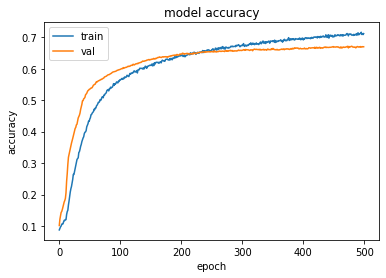

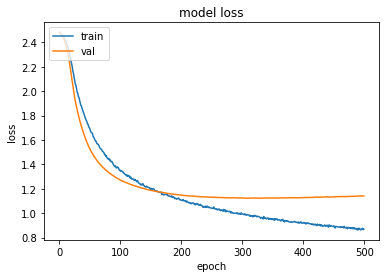

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
results = model.evaluate(test_ds, test_lb)

print(results)

4400/4400 [==============================] - 0s 64us/sample - loss: 1.1019 - acc: 0.6707
[1.1018905407732182, 0.67068183]


In [18]:
from tag_handler import get_category_title_dict

predictions = model.predict(test_ds)
cat_tit_dict = get_category_title_dict('data/json/CA_category_id.json')
cat_tit_dict.update(get_category_title_dict('data/json/US_category_id.json'))
cat_tit_dict.update(get_category_title_dict('data/json/GB_category_id.json'))

In [19]:
from sklearn.metrics import classification_report
print(classification_report(test_lb, np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           1       0.83      0.57      0.67       417
           2       0.59      0.76      0.67       390
           3       0.86      0.79      0.83       385
           4       0.69      0.68      0.68       424
           5       0.38      0.40      0.39       421
           6       0.79      0.67      0.72       392
           7       0.44      0.47      0.46       388
           8       0.66      0.74      0.70       405
           9       0.63      0.81      0.71       388
          10       0.88      0.81      0.84       401
          11       0.86      0.69      0.76       389

    accuracy                           0.67      4400
   macro avg       0.69      0.67      0.68      4400
weighted avg       0.69      0.67      0.67      4400



In [21]:
for i in range(30, 40):
    y_pred = reversed_new_categories_dict[np.argmax(predictions[i])]
    label = reversed_new_categories_dict[test_lb.values[i]]
    print('""""""""""""""""""""""""""""""""""""""""""""""""')
    print('predict:{}'.format(cat_tit_dict[str(y_pred)]))
    print('true label:{}'.format(cat_tit_dict[str(label)]))

""""""""""""""""""""""""""""""""""""""""""""""""
predict:Music
true label:Music
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Comedy
true label:Comedy
""""""""""""""""""""""""""""""""""""""""""""""""
predict:People & Blogs
true label:People & Blogs
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Music
true label:Film & Animation
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Sports
true label:Sports
""""""""""""""""""""""""""""""""""""""""""""""""
predict:News & Politics
true label:Film & Animation
""""""""""""""""""""""""""""""""""""""""""""""""
predict:People & Blogs
true label:Film & Animation
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Sports
true label:Sports
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Film & Animation
true label:Film & Animation
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Howto & Style
true label:Howto & Style
